In [1]:
from google.colab import drive
drive.mount('/content/drive')

%pip install adversarial-robustness-toolbox  # HOW TO INSTALL

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:00


# The Adversarial Robustness Toolbox from IBM Research



## Introduction

Adversarial Robustness Toolbox (ART) is a Python library for Machine Learning Security. It provides tools that enable developers and researchers to defend and evaluate Machine Learning models and applications against the adversarial threats of **Evasion, Poisoning, Extraction, and Inference**.

![white_hat_blue_red](https://drive.google.com/uc?export=view&id=1dCxNWDy5jGad1UKxZRCMpLgMF-QUibhH)

ART supports all popular machine learning frameworks (TensorFlow, Keras, PyTorch, MXNet, scikit-learn, XGBoost, LightGBM, CatBoost, GPy, etc.), all data types (images, tables, audio, video, etc.) and machine learning tasks (classification, object detection, speech recognition, generation, certification, etc.).

It is available at: https://github.com/Trusted-AI/adversarial-robustness-toolbox

---

Here are some useful references:

https://www.youtube.com/watch?v=tTN_BqTv440

https://www.youtube.com/watch?v=TygPgJYKRUI

https://www.youtube.com/watch?v=BDxTVOimUec

---


# More on Attacks

## Import necessary libraries

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent # Can directly import the attack. Explore this function
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist  # The library also contains the common datasets like MNIST and CIFAR10

## Step 0: Define the neural network model, return logits instead of activation in forward method

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

## Step 1: Load MNIST Data

MNIST is an image dataset of handwritten digits (28 pixels by 28 pixels) in grayscale. This is often thought to be the "hello, world!" of image classification/computer vision problems -- much like the Iris flower dataset is for non-NN-based machine learning.

In [4]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [5]:
print("The shape of x_train is: ", np.shape(x_train))
print("The shape of y_train is: ", np.shape(y_train))
print("The shape of x_test is: ", np.shape(x_test))
print("The shape of y_test is: ", np.shape(y_test))

The shape of x_train is:  (60000, 28, 28, 1)
The shape of y_train is:  (60000, 10)
The shape of x_test is:  (10000, 28, 28, 1)
The shape of y_test is:  (10000, 10)


## Step 1a: Visualise the data (Benign Training Data)

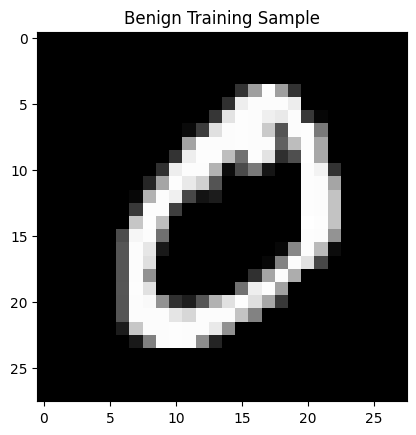

In [6]:
plt.imshow(x_train[1,...].squeeze(), cmap='gray')  # This is the second sample
plt.title("Benign Training Sample")
plt.show()

## Step 1b: Swap axes to Pytorch's B x CHW format

In [7]:
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

print("The shape of x_train is: ", np.shape(x_train))  # Black or white == 1 channel
print("The shape of y_train is: ", np.shape(y_train))
print("The shape of x_test is: ", np.shape(x_test))
print("The shape of y_test is: ", np.shape(y_test))

The shape of x_train is:  (60000, 1, 28, 28)
The shape of y_train is:  (60000, 10)
The shape of x_test is:  (10000, 1, 28, 28)
The shape of y_test is:  (10000, 10)


## Step 2: Create the model

In [8]:
model = Net()

## Step 2a: Define the loss function and the classifier

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Step 3: Create the classifier to use with ART

In [10]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),  # Note the input shape
    nb_classes=10,  # Number of classes is defined as 10
)

## Step 4: Train the classifier

In [11]:
num_epochs = 3
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=num_epochs)

## Step 5: Evaluate the ART classifier on benign (untampered) test examples

In [12]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {:3}%".format(accuracy * 100))

Accuracy on benign test examples: 98.15%


## Step 6: Generate adversarial test examples

In [13]:
epsilon = 0.2
attack = FastGradientMethod(estimator=classifier, eps=epsilon)
x_test_adv = attack.generate(x=x_test)

## Step 6a: Compare the benign with the adversarial sample

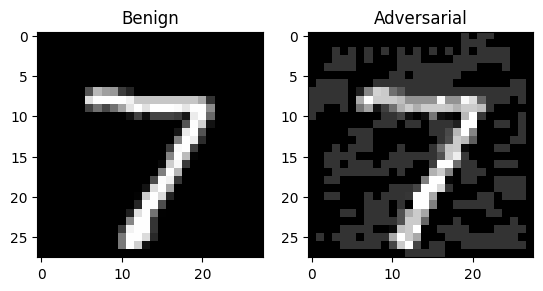

In [14]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_test[0,...].squeeze(), cmap='gray')
axarr[0].set_title('Benign')
axarr[1].imshow(x_test_adv[0,...].squeeze(), cmap='gray')
axarr[1].set_title('Adversarial')
plt.show()

## Step 7: Evaluate the ART classifier on adversarial test examples

In [18]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on normal test examples: {:3}%".format(accuracy * 100))

print("-----")

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {:3}%".format(accuracy * 100))

Accuracy on normal test examples: 98.15%
-----
Accuracy on adversarial test examples: 39.06%


# One Method of Defence - Adversarial Training/Data Augmentation

## Let's now try to create more adversarial examples but this time for training

In [16]:
adv_crafter = FastGradientMethod(estimator=classifier, eps=0.2)
x_train_adv = adv_crafter.generate(x_train)

print("The shape of x_train_adv is: ", np.shape(x_train_adv))

The shape of x_train_adv is:  (60000, 1, 28, 28)


## Data augmentation step

In [19]:
# Expand the training set with the adversarial samples
x_train = np.append(x_train, x_train_adv, axis=0)
y_train = np.append(y_train, y_train, axis=0)  # Repeats the labels

In [20]:
print("The shape of x_train is: ", np.shape(x_train))
print("The shape of y_train is: ", np.shape(y_train))
print("The shape of x_test is: ", np.shape(x_test))
print("The shape of y_test is: ", np.shape(y_test))

The shape of x_train is:  (120000, 1, 28, 28)
The shape of y_train is:  (120000, 10)
The shape of x_test is:  (10000, 1, 28, 28)
The shape of y_test is:  (10000, 10)


## Let's not just double our training dataset size. Sample from it

In [21]:
# Shuffle the arrays
shuffle_indices = np.random.permutation(len(x_train))  # Generate random permutation
x_train_shuffled = x_train[shuffle_indices]
y_train_shuffled = y_train[shuffle_indices]

# Take the first n samples  (keep the size of x_train the same)
n = len(x_train)//2
x_train_new = x_train_shuffled[:n]
y_train_new = y_train_shuffled[:n]

## Let's create a new CNN-based classifier for "Robust" Training

In [28]:
robust_classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),  # Note the input shape
    nb_classes=10,  # Number of classes is defined as 10
)

## Train the classifier on the new dataset OR just re-train the old one

In [29]:
num_epochs = 3
robust_classifier.fit(x_train_new, y_train_new, batch_size=64, nb_epochs=num_epochs)

## Re-evaluate the adversarially trained classifier on the test set

In [30]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on normal test examples: {:3}%".format(accuracy * 100))

print("-----")

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {:3}%".format(accuracy * 100))

Accuracy on normal test examples: 97.5%
-----
Accuracy on adversarial test examples: 95.22%


## **... Next steps:**

Some other resources:
- https://github.com/fra31/auto-attack
- https://robustbench.github.io/
- https://github.com/bethgelab/foolbox
- https://github.com/cleverhans-lab/cleverhans

Some noteworthy researchers whose work you could look into:
- Ian Goodfellow - https://scholar.google.ca/citations?hl=en&user=iYN86KEAAAAJ&view_op=list_works&sortby=pubdate
- Florian Tramèr - https://scholar.google.ch/citations?hl=en&user=ijH0-a8AAAAJ&view_op=list_works&sortby=pubdate
- Nicholas Carlini - https://scholar.google.com/citations?hl=en&user=q4qDvAoAAAAJ&view_op=list_works&sortby=pubdate
- Nicolas Papernot - https://scholar.google.com/citations?hl=en&user=cGxq0cMAAAAJ&view_op=list_works&sortby=pubdate
- Lorenzo Cavallaro (UCL) - https://scholar.google.com/citations?hl=en&user=oWT7fIYAAAAJ&view_op=list_works&sortby=pubdate


